# Milestone 2

# Introduction

Name: Karina Maharani Utomo
<br>
Batch: 003
<br>
Hactiv8 Full Time Data Science

This milestone project utilises a Goodreads dataset that can be accessed [here](https://www.kaggle.com/meetnaren/goodreads-best-books)

The dataset includes information about a book's title, author, description, edition, format, isbn, number of pages, average rating, number of ratings, reviews, genres, and cover

The objective of this Milestone project is to classify the books into two categories: Fiction and Nonfiction, based on their description using Natural Language Processing (NLP)


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install langdetect
from langdetect import detect

from sklearn.model_selection import train_test_split
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix , classification_report

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
raw = pd.read_csv('/content/gdrive/MyDrive/data hacktiv8/book_data.csv')
raw.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [4]:
raw.shape

(54301, 12)

This dataset consists of 54301 rows and 12 columns

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_authors       54301 non-null  object 
 1   book_desc          52970 non-null  object 
 2   book_edition       5453 non-null   object 
 3   book_format        52645 non-null  object 
 4   book_isbn          41435 non-null  object 
 5   book_pages         51779 non-null  object 
 6   book_rating        54301 non-null  float64
 7   book_rating_count  54301 non-null  int64  
 8   book_review_count  54301 non-null  int64  
 9   book_title         54301 non-null  object 
 10  genres             51059 non-null  object 
 11  image_url          53618 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.0+ MB


For this project, the features that will be needed are `book_desc` and `genres`. The features `book_authors` and `book_title` will be selected for this part to make the process of identifying the book easier, if needed

In [6]:
data = raw[['book_authors', 'book_title', 'book_desc', 'genres']]
data.head()

,book_authors,book_title,book_desc,genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Pride and Prejudice,«È cosa ormai risaputa che a uno scapolo in po...,Classics|Fiction|Romance
4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...


# Data Cleaning

In [7]:
# Checking for missing values

data.isnull().sum()

book_authors       0
book_title         0
book_desc       1331
genres          3242
dtype: int64

In [8]:
data.isnull().sum()/len(data)*100

book_authors    0.000000
book_title      0.000000
book_desc       2.451152
genres          5.970424
dtype: float64

There are missing values in `book_desc` and `genres`. The missing values will be dropped, since the amount aren't that many

In [9]:
data.dropna(subset = ['book_desc', 'genres'], inplace = True)
data.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


book_authors    0
book_title      0
book_desc       0
genres          0
dtype: int64

In [10]:
data.shape

(50177, 4)

The dataset now has 50177 rows

In [11]:
data.reset_index(inplace = True)
data.tail()

,index,book_authors,book_title,book_desc,genres
50172,54295,Avi Steinberg,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,Nonfiction|Autobiography|Memoir|Biography|Writ...
50173,54296,Howard Megdal,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...",Sports|Baseball|Sports and Games|Sports|Nonfic...
50174,54297,Howard Megdal,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,Nonfiction|Sports and Games|Sports
50175,54299,Mimi Baird|Eve Claxton,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...",Nonfiction|Autobiography|Memoir|Biography|Psyc...
50176,54300,Leah Price,The Anthology and the Rise of the Novel: From ...,The Anthology and the Rise of the Novel brings...,Criticism|Literary Criticism|Philosophy|Theory...


In [12]:
data.drop('index', axis = 1, inplace = True)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,book_authors,book_title,book_desc,genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Pride and Prejudice,«È cosa ormai risaputa che a uno scapolo in po...,Classics|Fiction|Romance
4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...
...,...,...,...,...
50172,Avi Steinberg,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,Nonfiction|Autobiography|Memoir|Biography|Writ...
50173,Howard Megdal,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...",Sports|Baseball|Sports and Games|Sports|Nonfic...
50174,Howard Megdal,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,Nonfiction|Sports and Games|Sports
50175,Mimi Baird|Eve Claxton,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...",Nonfiction|Autobiography|Memoir|Biography|Psyc...


# Data Exploration

## Language of book description

From the dataset above, it can be seen that there are descriptions of a book that are not in English. For example, the book description of index 3. Before continuing, the language of each book's description needs to be identified first.

If there are descriptions that are invalid, they will be dropped

In [13]:
invalid_desc_id = []

for i in data.index:
  try:
    a = detect(data.at[i,'book_desc'])
  except:
    invalid_desc_id.append(i)
    
data = data.drop(index = invalid_desc_id)

In [14]:
data.shape

(50172, 4)

In [15]:
data['language'] = data['book_desc'].map(lambda desc: detect(desc))
data.head()

,book_authors,book_title,book_desc,genres,language
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Pride and Prejudice,«È cosa ormai risaputa che a uno scapolo in po...,Classics|Fiction|Romance,it
4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en


It can be seen that the languages are still in two-letter codes. To get the name of the languages, a list from Wikipedia will be used to map the code to the language name

In [16]:
lang_dict = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-1_codes')[1]
lang_pd = lang_dict[['ISO language name','639-1']]
lang_pd.columns = ['language','iso']

In [17]:
lang_pd.head()

,language,iso
0,Abkhazian,ab
1,Afar,aa
2,Afrikaans,af
3,Akan,ak
4,Albanian,sq


In [18]:
# Creating a new column for the language name

def desc_lang(x):
    if x in list(lang_pd['iso']):
        return lang_pd[lang_pd['iso'] == x]['language'].values[0]
    else:
        return 'NaN'

data['language_name'] = data['language'].apply(desc_lang)
data.head()

,book_authors,book_title,book_desc,genres,language,language_name
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Pride and Prejudice,«È cosa ormai risaputa che a uno scapolo in po...,Classics|Fiction|Romance,it,Italian
4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English


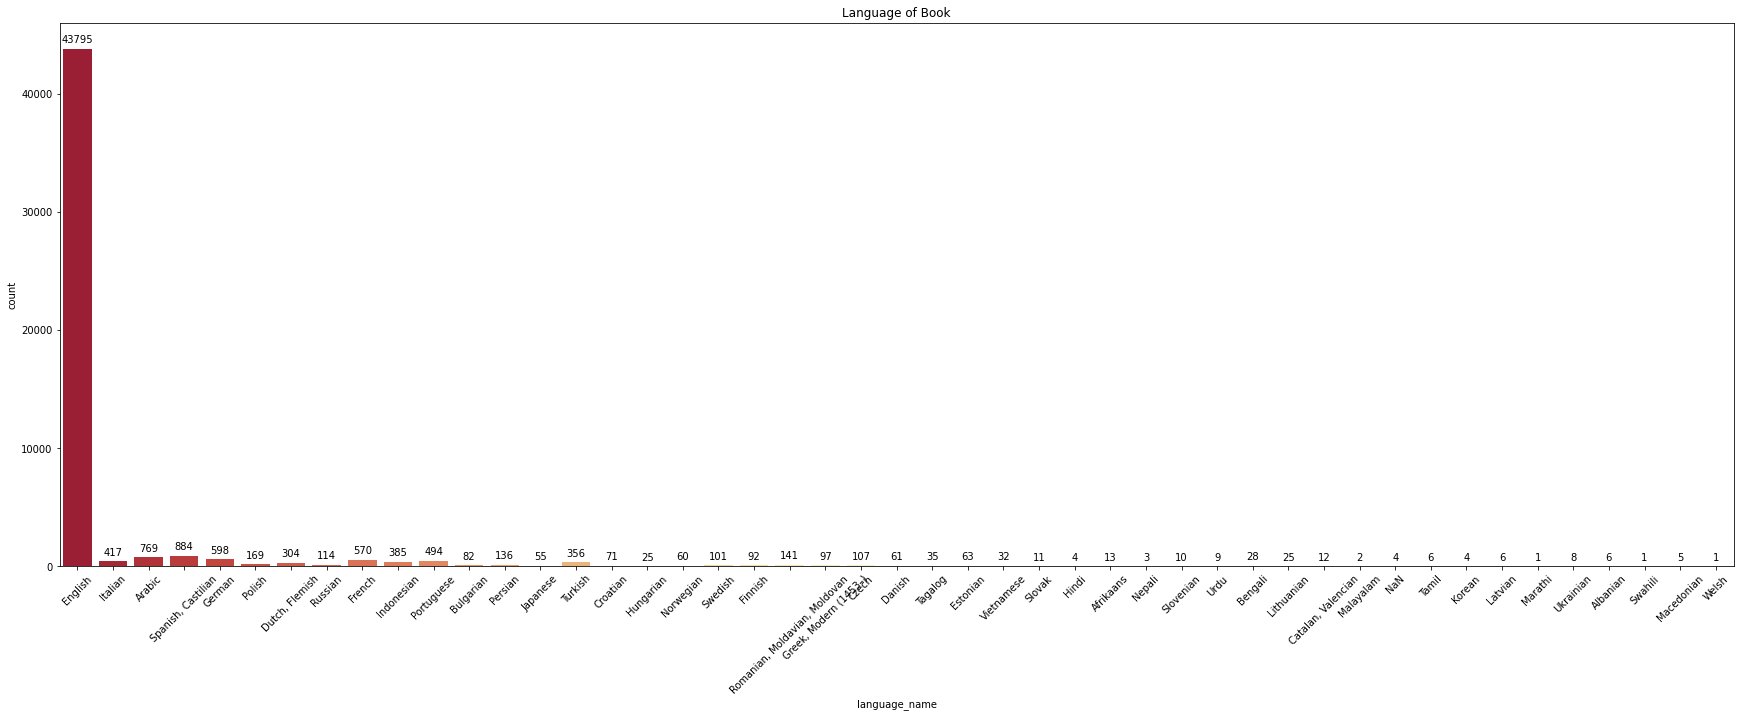

In [19]:
plt.figure(figsize = (30,10))

lang_plot = sns.countplot(x = data['language_name'], palette = 'RdYlBu')
for p in lang_plot.patches:
    lang_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.title('Language of Book')

plt.show()

As most of the descriptions are in English, to make the process of model building easier, descriptions in other languages will not be included in the next steps

In [20]:
data = data[data['language_name']=='English']
data.reset_index(inplace = True)
data.tail()

,index,book_authors,book_title,book_desc,genres,language,language_name
43790,50172,Avi Steinberg,Running the Books: The Adventures of an Accide...,Avi Steinberg is stumped. After defecting from...,Nonfiction|Autobiography|Memoir|Biography|Writ...,en,English
43791,50173,Howard Megdal,Taking the Field: A Fan's Quest to Run the Tea...,"In this fearless and half-crazy story, Howard ...",Sports|Baseball|Sports and Games|Sports|Nonfic...,en,English
43792,50174,Howard Megdal,"The Baseball Talmud: Koufax, Greenberg, and th...",From the icons of the game to the players who ...,Nonfiction|Sports and Games|Sports,en,English
43793,50175,Mimi Baird|Eve Claxton,He Wanted the Moon: The Madness and Medical Ge...,"Soon to be a major motion picture, from Brad P...",Nonfiction|Autobiography|Memoir|Biography|Psyc...,en,English
43794,50176,Leah Price,The Anthology and the Rise of the Novel: From ...,The Anthology and the Rise of the Novel brings...,Criticism|Literary Criticism|Philosophy|Theory...,en,English


In [21]:
data['language_name'].value_counts()

English    43795
Name: language_name, dtype: int64

There are 43791 rows of data that will be used

## Genres of book

In this dataset, each book has a list of genres. These genres need to be separated from each other, so that the amount of unique genres in this dataset and the amount of genres a book has can be counted

In [22]:
print('List of genres from the dataset    :', data.loc[0]['genres'])
print('The genres after they\'re separated:', data.loc[0]['genres'].split('|'))
print('The amount of genres in that book  :', len(data.loc[0]['genres'].split('|')))

List of genres from the dataset    : Young Adult|Fiction|Science Fiction|Dystopia|Fantasy|Science Fiction
The genres after they're separated: ['Young Adult', 'Fiction', 'Science Fiction', 'Dystopia', 'Fantasy', 'Science Fiction']
The amount of genres in that book  : 6


In [23]:
# Funtion to count the number of genres in a book

def num_of_genres(x):
  return len(x.split('|'))

data['num_of_genres'] = data['genres'].map(lambda x: num_of_genres(x))

In [24]:
data.head()

,index,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres
0,0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6
1,1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3
2,2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6
3,4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8
4,5,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4


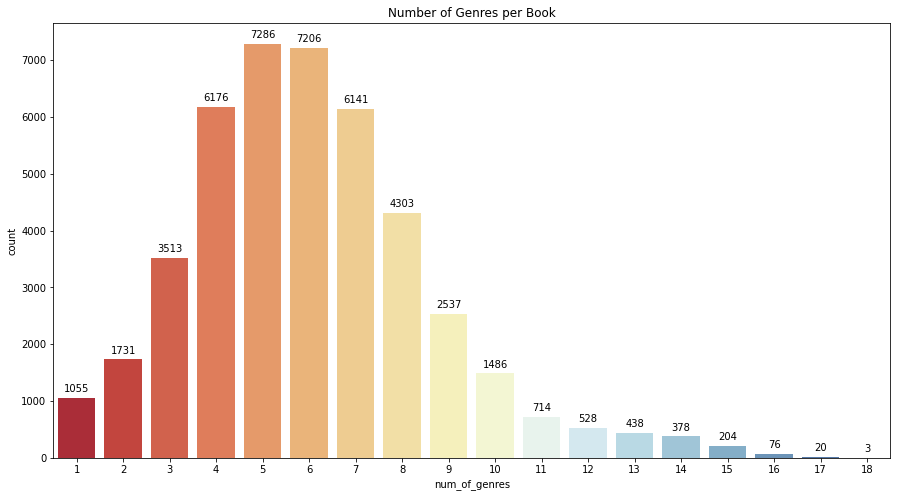

In [25]:
plt.figure(figsize = (15,8))

num_plot = sns.countplot(x = data['num_of_genres'], palette = 'RdYlBu')
for p in num_plot.patches:
    num_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Number of Genres per Book')
    
plt.show()

Most of the books are classified into 5-6 different genres. There is also a few books that are classified into 16-18 genres

In [26]:
# Function to separate the genres in a book

def list_of_genres(x):
  return (x.split('|'))

data['list_of_genres'] = data['genres'].map(lambda x: list_of_genres(x))
data.head()

,index,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres
0,0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop..."
1,1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]"
2,2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic..."
3,4,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va..."
4,5,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn..."


In [27]:
data.drop('index', axis = 1, inplace = True)
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop..."
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]"
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic..."
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va..."
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn..."


In [28]:
# Listing all the unique genres in this dataset

gens = set()
for i in range(len(data)):
  for j in range(len(data['list_of_genres'][i])):
      gens.add(data['list_of_genres'][i][j])

In [29]:
# Counting the number of books in each genre

gen_dict = {i:0 for i in gens}

for i in range(len(data)):
    for j in range(len(data['list_of_genres'][i])):
        gen_dict[data['list_of_genres'][i][j]]+=1

In [30]:
len(gen_dict)

850

There are a total of 850 different genres in this dataset. Here are the top 5 genres

In [31]:
gen_pd = pd.DataFrame.from_records(sorted(gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['genre', 'count'])
gen_pd.head()

,genre,count
0,Fiction,22338
1,Fantasy,21630
2,Romance,17356
3,Young Adult,10295
4,Historical,9694


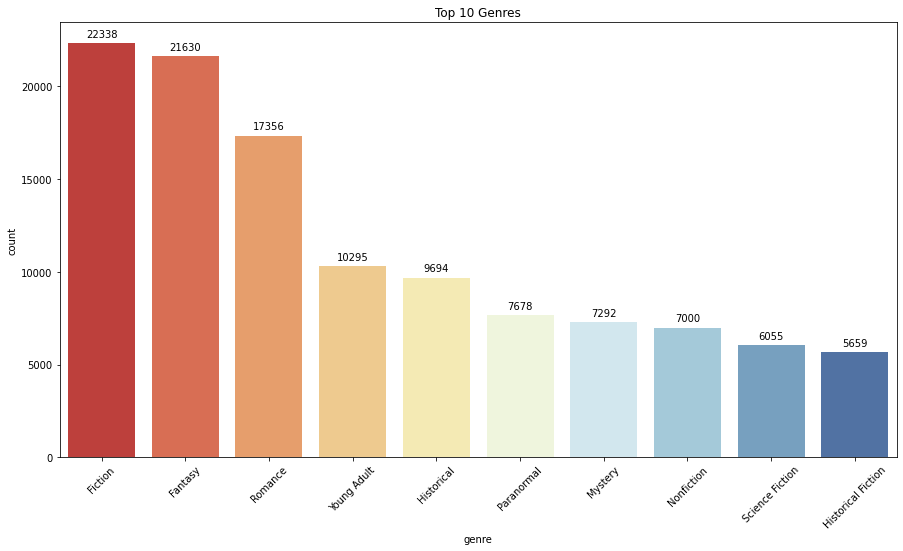

In [32]:
gen_10 = gen_pd[:10]

plt.figure(figsize = (15,8))

gen_plot = sns.barplot(data = gen_10, x = gen_10['genre'], y = gen_10['count'], palette = 'RdYlBu')
for p in gen_plot.patches:
    gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.title('Top 10 Genres')

plt.show()

From the top 10 genres, two of them are 'Fiction' and 'Nonfiction'. Since every book can be classified into one of those genres, this Milestone Project will be focusing on that

So for the next step, a new column will be added to label the book as simply Fiction or Nonfiction. The books that don't have 'Fiction' or 'Nonfiction' in their list of genres will be used in the Model Inference section of this Notebook

In [33]:
def determine_label(x):
    if 'Fiction' in x:
        return 'Fiction'
    elif 'Nonfiction' in x:
        return 'Nonfiction'
    else:
        return 'Not Determined'

In [34]:
data['label'] = data['list_of_genres'].apply(determine_label)
data.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic...",Fiction
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn...",Fiction


In [35]:
fiction = data[data['label'] == 'Fiction'].reset_index()
fiction.shape

(22338, 10)

There are 22337 books that are classified as Fiction in this dataset

In [36]:
fic_gens = set()
for i in range(len(fiction)):
  for j in range(len(fiction['list_of_genres'][i])):
      fic_gens.add(fiction['list_of_genres'][i][j])

In [37]:
fic_gen_dict = {i:0 for i in fic_gens}

for i in range(len(fiction)):
    for j in range(len(fiction['list_of_genres'][i])):
        fic_gen_dict[fiction['list_of_genres'][i][j]]+=1

In [38]:
len(fic_gen_dict)

605

For the fictional books, there are 605 unique genres. The top 5 are as follows:

In [39]:
fic_gen_pd = pd.DataFrame.from_records(sorted(fic_gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['fiction genre', 'count'])
fic_gen_pd.head()

,fiction genre,count
0,Fiction,22338
1,Fantasy,9971
2,Historical,7446
3,Mystery,5876
4,Young Adult,5095


In [40]:
nonfiction = data[data['label'] == 'Nonfiction'].reset_index()
nonfiction.shape

(7000, 10)

As for the Nonfiction, there are 7000 books that are classified in that genre

In [41]:
nonfic_gens = set()
for i in range(len(nonfiction)):
  for j in range(len(nonfiction['list_of_genres'][i])):
      nonfic_gens.add(nonfiction['list_of_genres'][i][j])

In [42]:
nonfic_gen_dict = {i:0 for i in nonfic_gens}

for i in range(len(nonfiction)):
    for j in range(len(nonfiction['list_of_genres'][i])):
        nonfic_gen_dict[nonfiction['list_of_genres'][i][j]]+=1

In [43]:
len(nonfic_gen_dict)

565

There are 565 unique genres for the non-fictional books. The top 5 are as follows:

In [44]:
nonfic_gen_pd = pd.DataFrame.from_records(sorted(nonfic_gen_dict.items(), key = lambda x:x[1], reverse=True), 
                                     columns=['nonfiction genre', 'count'])
nonfic_gen_pd.head()

,nonfiction genre,count
0,Nonfiction,7000
1,Biography,2427
2,History,2350
3,Religion,1925
4,Autobiography,1913


Below are the distribution of genres for the fictional and non-fictional books

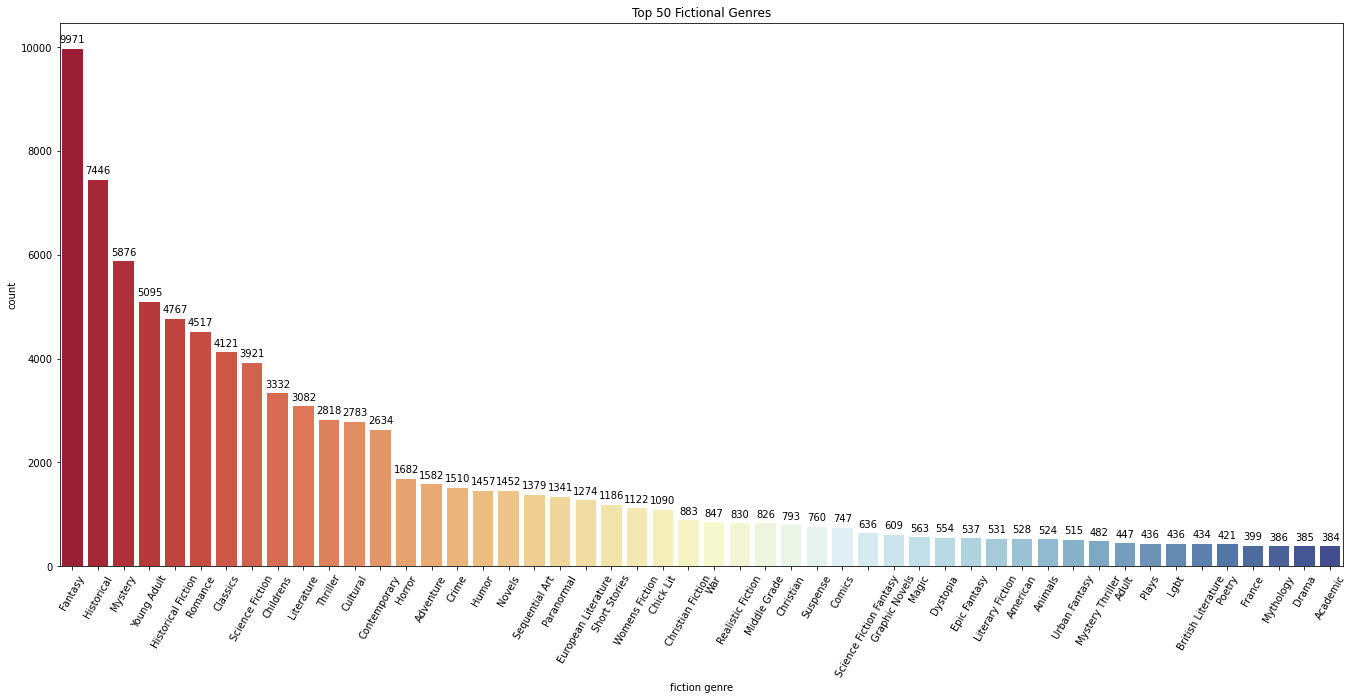

In [45]:
fic_gen_50 = fic_gen_pd[1:51]

plt.figure(figsize = (23,10))

fic_gen_plot = sns.barplot(data = fic_gen_50, x = fic_gen_50['fiction genre'], y = fic_gen_50['count'], palette = 'RdYlBu')
for p in fic_gen_plot.patches:
    fic_gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=60)
plt.title('Top 50 Fictional Genres')

plt.show()

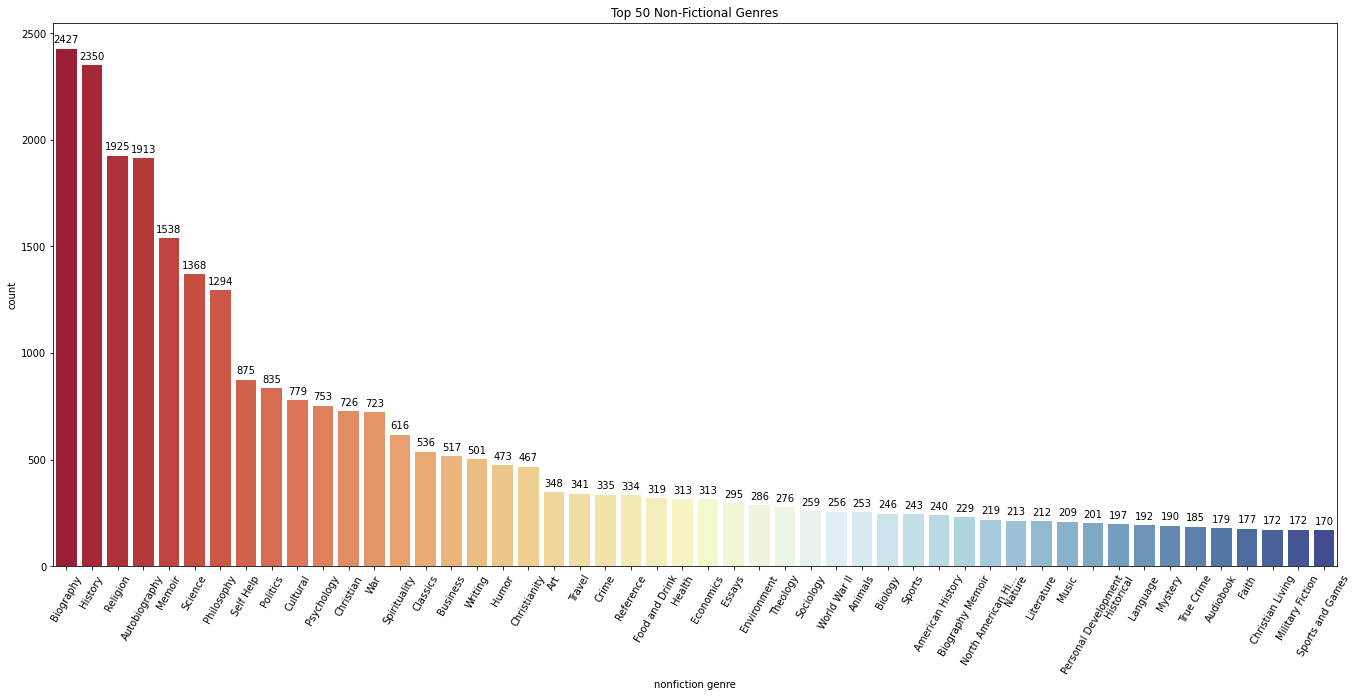

In [46]:
nonfic_gen_50 = nonfic_gen_pd[1:51]

plt.figure(figsize = (23,10))

nonfic_gen_plot = sns.barplot(data = nonfic_gen_50, x = nonfic_gen_50['nonfiction genre'], y = nonfic_gen_50['count'], palette = 'RdYlBu')
for p in nonfic_gen_plot.patches:
    nonfic_gen_plot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=60)
plt.title('Top 50 Non-Fictional Genres')

plt.show()

For the fictional books, the genre with the most book is Fantasy. As for the non-fictional books, it's Biography

# Data Preprocessing

As mentioned before, the books that aren't labeled as Fiction or Nonfiction will be used for Model Inference. As for the books that are labeled, they will be used for model building

In [47]:
data_model = data[data['label'] != 'Not Determined']
data_model.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",Fiction
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",Fiction
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic...",Fiction
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",Fiction
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn...",Fiction


The labels will be encoded first, to make the next steps easier

In [48]:
data_model['label'].replace({'Fiction': 1,'Nonfiction': 0},inplace=True)
data_model.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",1
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",1
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic...",1
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",1
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn...",1


In [49]:
t1 = data_model[data_model['label'] == 1]['genres'].count()
t0 = data_model[data_model['label'] == 0]['genres'].count()
length = len(data_model)

print(f'Fiction   : {t1}  ({((t1/length)*100).round(3)} %)')
print(f'Nonfiction: {t0} ({((t0/length)*100).round(3)} %)')

Fiction   : 22338  (76.14 %)
Nonfiction: 7000 (23.86 %)


It can be seen that the data is imbalanced, but we will leave it be for now.

Next, the description of the book needs to be cleaned. That means removing non-ascii characters, turn all letters into lowercase, replace shortened words with their formal form (for example: i'm will be turned into i am), filtering out punctuations, and removing numbers

In [50]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def cleaner(df):
    df['clean_desc'] = df['book_desc'].apply(clean_text)
    return df

In [51]:
data_model = cleaner(data_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [52]:
data_model.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc
0,Suzanne Collins,The Hunger Games,Winning will make you famous. Losing means cer...,Young Adult|Fiction|Science Fiction|Dystopia|F...,en,English,6,"[Young Adult, Fiction, Science Fiction, Dystop...",1,winning will make you famous losing means cert...
1,J.K. Rowling|Mary GrandPré,Harry Potter and the Order of the Phoenix,There is a door at the end of a silent corrido...,Fantasy|Young Adult|Fiction,en,English,3,"[Fantasy, Young Adult, Fiction]",1,there is a door at the end of a silent corrido...
2,Harper Lee,To Kill a Mockingbird,The unforgettable novel of a childhood in a sl...,Classics|Fiction|Historical|Historical Fiction...,en,English,6,"[Classics, Fiction, Historical, Historical Fic...",1,the unforgettable novel of a childhood in a sl...
3,Stephenie Meyer,Twilight,About three things I was absolutely positive.F...,Young Adult|Fantasy|Romance|Paranormal|Vampire...,en,English,8,"[Young Adult, Fantasy, Romance, Paranormal, Va...",1,about three things i was absolutely positive f...
4,Markus Zusak,The Book Thief,Trying to make sense of the horrors of World W...,Historical|Historical Fiction|Fiction|Young Adult,en,English,4,"[Historical, Historical Fiction, Fiction, Youn...",1,trying to make sense of the horrors of world w...


In [53]:
print('Initial book description:\n', data_model['book_desc'][0])
print()
print('Cleaned book description:\n', data_model['clean_desc'][0])

Initial book description:
 Winning will make you famous. Losing means certain death.The nation of Panem, formed from a post-apocalyptic North America, is a country that consists of a wealthy Capitol region surrounded by 12 poorer districts. Early in its history, a rebellion led by a 13th district against the Capitol resulted in its destruction and the creation of an annual televised event known as the Hunger Games. In punishment, and as a reminder of the power and grace of the Capitol, each district must yield one boy and one girl between the ages of 12 and 18 through a lottery system to participate in the games. The 'tributes' are chosen during the annual Reaping and are forced to fight to the death, leaving only one survivor to claim victory.When 16-year-old Katniss's young sister, Prim, is selected as District 12's female representative, Katniss volunteers to take her place. She and her male counterpart Peeta, are pitted against bigger, stronger representatives, some of whom have tr

## Splitting Data

Next, the data will be split into training and validation data

In [54]:
X = data_model['clean_desc']
y = data_model['label']

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=True, stratify = y)

In [56]:
# Melihat hasil splitting data

print('Precentage of data used for training data  :', '%.2f' % ((len(X_train)/len(X))*100), '%')
print('Precentage of data used for validation data:', '%.2f' % ((len(X_val)/len(X))*100), '%')
print()

print('Amount of rows in training data  :', X_train.shape[0])
print('Amount of rows in validation data:', X_val.shape[0])

Precentage of data used for training data  : 80.00 %
Precentage of data used for validation data: 20.00 %

Amount of rows in training data  : 23470
Amount of rows in validation data: 5868


In [57]:
print('Precentage of Nonfiction book data')
print()
print('Initial dataset:', '%.3f' % ((sum(data_model['label'] == 0)/len(data_model['label']))*100), '%')
print('Training data  :', '%.3f' % ((sum(y_train == 0)/len(y_train))*100), '%')
print('Validation data:', '%.3f' % ((sum(y_val == 0)/len(y_val))*100), '%')

Precentage of Nonfiction book data

Initial dataset: 23.860 %
Training data  : 23.860 %
Validation data: 23.858 %


## Preprocessing Training Data

These is what's going to be done in the preprocessing stage:
- **Removing stopwords**: Stopwords are often added to sentences to make them grammatically correct, for example, words such as a, is, an, the, and etc. These stopwords carry minimal to no importance and are available plenty on open texts, articles, comments etc. These should be removed so machine learning algorithms can better focus on words which define the meaning/idea of the text. We are using list from nltk.corpus and this list can further be enhanced by adding or removing custom words based on the situation at hand
- **Splitting sentence into words with a tokenizer**: Tokenizers divide strings into lists of substrings. For example, tokenizers can be used to find the list of sentences or words in a string. 
- **Lemmatization**: Lemmatization is an advanced form of stemming. Stemming might not result in actual word, whereas lemmatization does conversion properly with the use of vocabulary, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. For example, eating will be replaced by eat.

[reference](https://towardsdatascience.com/nlp-building-text-cleanup-and-preprocessing-pipeline-eba4095245a0)

In [58]:
X_train_trf = X_train.copy()

In [59]:
# download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [60]:
x_tokenized = []
stop_words = set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

for x in X_train_trf.values:
  tmp = []
  sent_token = sent_tokenize(x)
  for sents in sent_token:
    word_token = tokenizer.tokenize(sents)
    filtered = [w.strip() for w in word_token if w not in stop_words and len(w) > 1]
    for words in filtered:
      lemm = lemmatizer.lemmatize(words)
      words = lemm
    tmp.extend(filtered)
  x_tokenized.append(tmp)

In [61]:
X_train_trf.values[0]

'these classic fairy tales have left an indelible mark on western culture a testament to the brilliance and skill of jacob and wilhelm grimm'

In [62]:
len(x_tokenized[0])

14

The description above is now turned into a list of a few words as seen below

Note: reshaping the list so it will be nicer to see

In [63]:
np.reshape(x_tokenized[0], newshape = (1,len(x_tokenized[0])))

array([['classic', 'fairy', 'tales', 'left', 'indelible', 'mark',
        'western', 'culture', 'testament', 'brilliance', 'skill',
        'jacob', 'wilhelm', 'grimm']], dtype='<U10')

After the description of each book is split into words, the next step is to encode each word into numbers

In [64]:
t = Tokenizer()
t.fit_on_texts(x_tokenized)

In [65]:
X_train_seq = t.texts_to_sequences(x_tokenized)

In [66]:
np.reshape(X_train_seq[0], newshape = (1,len(x_tokenized[0])))

array([[  104,   838,   307,   132,  4924,   692,   859,   353,  1909,
         3548,  2054,  2776, 14773,  5819]])

In [67]:
word_idx = t.word_index
for word, idx in word_idx.items():
    print(f"{word}: {idx}")
    if idx == 5:
        break

one: 1
life: 2
new: 3
world: 4
story: 5


To make sure each book description has the same amount of words in its list, we will set the length to 1.5 times the mean of number of words in a book description after preprocessing. The number we get is 120. So if a length of a book description is more than that, it will be trimmed. If the length is shorter, we will fill the gap with paddings

In [68]:
tem = 0
for i in range(len(X_train_seq)):
    tem += len(X_train_seq[i])
invec = int(1.5*tem/len(X_train_seq))

In [69]:
invec

120

In [70]:
X_train_pad = pad_sequences(X_train_seq, maxlen=invec)

In [71]:
np.reshape(X_train_seq[0], newshape = (1,len(x_tokenized[0])))

array([[  104,   838,   307,   132,  4924,   692,   859,   353,  1909,
         3548,  2054,  2776, 14773,  5819]])

In [72]:
len(X_train_seq[0])

14

In this case, the length of a book description is 14. That means we have to fill the remaining 116 spaces, to make it have a length of 120

In [73]:
X_train_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,   104,   838,
         307,   132,  4924,   692,   859,   353,  1909,  3548,  2054,
        2776, 14773,  5819], dtype=int32)

In [74]:
len(X_train_pad[0])

120

After that, we make a weight matrix using Word2Vec vector and keras tokenizer index. This will be used later in the model building section

In [75]:
w2v_model = Word2Vec(sentences=x_tokenized, min_count=5, workers=4)

In [76]:
word_index = t.word_index
for word, num in word_index.items():
    print(f"{word}: {num}")
    if num == 5:
        break

one: 1
life: 2
new: 3
world: 4
story: 5


In [77]:
vocab_size = len(t.word_index) + 1

def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
    for word, i in vocab.items():
        if word not in model:
            weight_matrix[i] = 0
        else:
            weight_matrix[i] = model[word]
    return weight_matrix

emvec = get_weight_matrix(w2v_model.wv, word_index)

Finally, to make the preprocessing step easier for validation data & model inference, all the steps that have been done on the training data will be compiled into one function

In [78]:
def tokenize_data(df):
  x_tokenized = []
  stop_words = set(stopwords.words("english"))
  tokenizer = RegexpTokenizer(r'\w+')
  lemmatizer = WordNetLemmatizer()

  for x in df.values:
    tmp = []
    sent_token = sent_tokenize(x)
    for sents in sent_token:
      word_token = tokenizer.tokenize(sents)
      filtered = [w.strip() for w in word_token if w not in stop_words and len(w) > 1]
      for words in filtered:
        lemm = lemmatizer.lemmatize(words)
        words = lemm
      tmp.extend(filtered)
    x_tokenized.append(tmp)
  return(x_tokenized)

In [79]:
def preprocess_data(data):
  X_tok = tokenize_data(data)
  X_seq = t.texts_to_sequences(X_tok)
  X_pad = pad_sequences(X_seq, maxlen=invec)
  return(X_pad)

## Preprocessing Validation Data

For the preprocessing of validation data, we will be using the function we've previously made

In [80]:
X_val_pad = preprocess_data(X_val)

In [81]:
X_val_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 11785,  7433,
        7903,    51,   298,   373,   493,   702,    71,    33,   147,
        7903,  2016,  2685, 22991,  3032,  6290, 39323, 45897, 25346,
          98,     8,  2652], dtype=int32)

# Defining Model

For the model, we will be using an LTSM base model as a start, that consists of one embedding layer, one LSTM layer, a dropout layer, and a sigmoid layer to classify the book description as either fiction or nonfiction.

- The embedding layer helps us reduce the dimensionality of the problem
- The dropout layer prevents overfitting by ignoring randomly selected neurons during training

For the activation and loss function, we will be using sigmoid and binary_crossentropy. Both of these are chosen because this is a binary classification problem


In [82]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(keras.layers.Embedding(vocab_size, output_dim=w2v_model.vector_size, weights=[emvec], input_length=invec, trainable=False))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

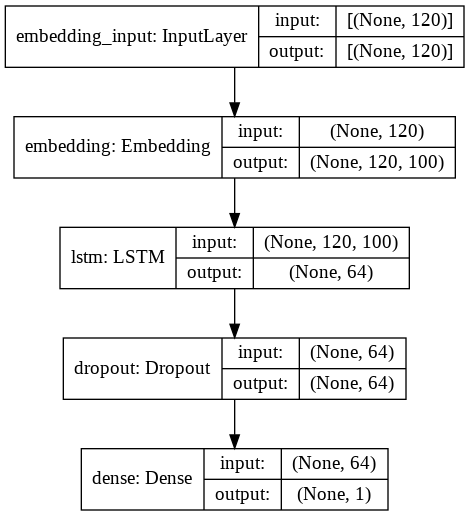

In [83]:
keras.utils.plot_model(model, show_shapes=True)

In [84]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          7723300   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 7,765,605
Trainable params: 42,305
Non-trainable params: 7,723,300
_________________________________________________________________


In [85]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

Early stopping will be used when no more progress is seen on the validation data, especially on the loss

In [86]:
history = model.fit(X_train_pad, y_train, epochs=5, verbose = 1, batch_size = 50,
                    validation_data = (X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/5
470/470 [==============================] - 46s 93ms/step - loss: 0.3172 - accuracy: 0.8732 - val_loss: 0.2605 - val_accuracy: 0.8942
Epoch 2/5
470/470 [==============================] - 54s 114ms/step - loss: 0.2435 - accuracy: 0.9027 - val_loss: 0.2591 - val_accuracy: 0.8984
Epoch 3/5
470/470 [==============================] - 59s 124ms/step - loss: 0.2203 - accuracy: 0.9142 - val_loss: 0.2417 - val_accuracy: 0.9099
Epoch 4/5
470/470 [==============================] - 47s 99ms/step - loss: 0.2093 - accuracy: 0.9170 - val_loss: 0.2239 - val_accuracy: 0.9093
Epoch 5/5
470/470 [==============================] - 45s 96ms/step - loss: 0.1973 - accuracy: 0.9213 - val_loss: 0.2070 - val_accuracy: 0.9211


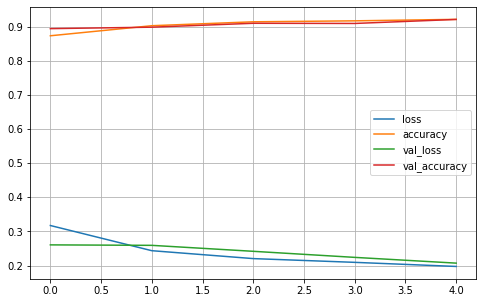

In [87]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

From the accuracy of training and validation data, it can be seen that the model doesn't appear to be overfitted

In [88]:
model.evaluate(X_val_pad,y_val)

184/184 [==============================] - 5s 24ms/step - loss: 0.2070 - accuracy: 0.9211


[0.2070159763097763, 0.921097457408905]

In [89]:
pred = model.predict(X_val_pad)
y_pred_model = []
for element in pred:
    if element > 0.5:
        y_pred_model.append(1)
    else :
        y_pred_model.append(0)

In [90]:
print(classification_report(y_val, y_pred_model))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1400
           1       0.94      0.96      0.95      4468

    accuracy                           0.92      5868
   macro avg       0.90      0.88      0.89      5868
weighted avg       0.92      0.92      0.92      5868



The performance of this model is already really good, with a 92% accuracy. The precision and recall of the Nonfiction classification are also pretty good, considering the data is imbalanced. Next, we will see if we can improve the model even more

# Model Improvement

In this part, we will see if adding another LTSM layer will improve the model or not

In [91]:
tf.keras.backend.clear_session()

model2 = Sequential()
model2.add(keras.layers.Embedding(vocab_size, output_dim=w2v_model.vector_size, weights=[emvec], input_length=invec, trainable=False))
model2.add(LSTM(120, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

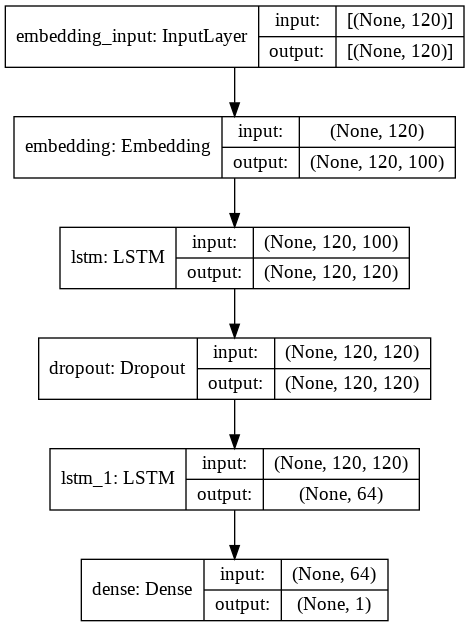

In [92]:
keras.utils.plot_model(model2, show_shapes=True)

In [93]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          7723300   
_________________________________________________________________
lstm (LSTM)                  (None, 120, 120)          106080    
_________________________________________________________________
dropout (Dropout)            (None, 120, 120)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                47360     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 7,876,805
Trainable params: 153,505
Non-trainable params: 7,723,300
_________________________________________________________________


In [94]:
history = model2.fit(X_train_pad, y_train, epochs=5, verbose = 1, batch_size = 50,
                    validation_data = (X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/5
470/470 [==============================] - 147s 304ms/step - loss: 0.3026 - accuracy: 0.8717 - val_loss: 0.2507 - val_accuracy: 0.8923
Epoch 2/5
470/470 [==============================] - 143s 305ms/step - loss: 0.2344 - accuracy: 0.9025 - val_loss: 0.2472 - val_accuracy: 0.9013
Epoch 3/5
470/470 [==============================] - 132s 280ms/step - loss: 0.2152 - accuracy: 0.9160 - val_loss: 0.2189 - val_accuracy: 0.9112
Epoch 4/5
470/470 [==============================] - 131s 280ms/step - loss: 0.1978 - accuracy: 0.9207 - val_loss: 0.2233 - val_accuracy: 0.9141
Epoch 5/5
470/470 [==============================] - 133s 282ms/step - loss: 0.1827 - accuracy: 0.9257 - val_loss: 0.2015 - val_accuracy: 0.9208


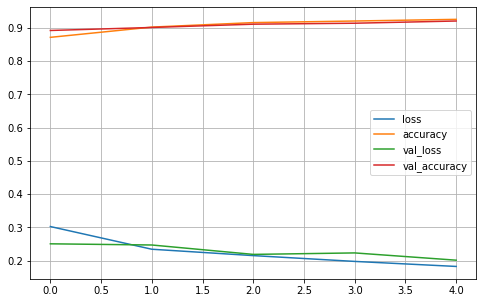

In [95]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [96]:
model2.evaluate(X_val_pad,y_val)

184/184 [==============================] - 12s 65ms/step - loss: 0.2015 - accuracy: 0.9208


[0.2014838606119156, 0.9207566380500793]

In [97]:
pred = model2.predict(X_val_pad)
y_pred_model2 = []
for element in pred:
    if element > 0.5:
        y_pred_model2.append(1)
    else :
        y_pred_model2.append(0)

In [98]:
print(classification_report(y_val, y_pred_model2))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1400
           1       0.94      0.96      0.95      4468

    accuracy                           0.92      5868
   macro avg       0.90      0.88      0.89      5868
weighted avg       0.92      0.92      0.92      5868



We will also see whether changing up the epoch number will make a difference in performance or not

In [99]:
tf.keras.backend.clear_session()

model3 = Sequential()
model3.add(keras.layers.Embedding(vocab_size, output_dim=w2v_model.vector_size, weights=[emvec], input_length=invec, trainable=False))
model3.add(LSTM(120, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(64))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])

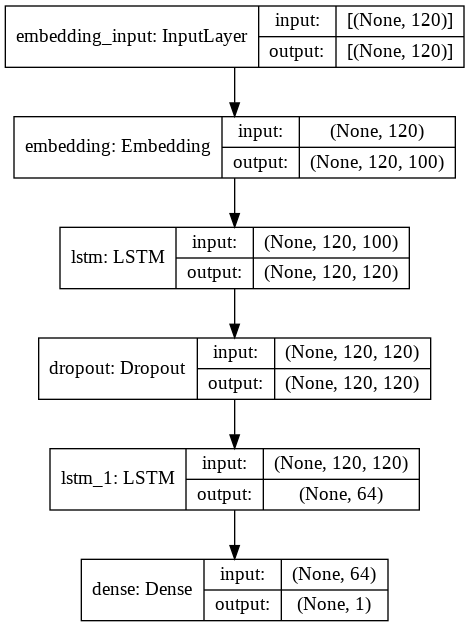

In [100]:
keras.utils.plot_model(model3, show_shapes=True)

In [101]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 100)          7723300   
_________________________________________________________________
lstm (LSTM)                  (None, 120, 120)          106080    
_________________________________________________________________
dropout (Dropout)            (None, 120, 120)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                47360     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 7,876,805
Trainable params: 153,505
Non-trainable params: 7,723,300
_________________________________________________________________


In [103]:
history = model3.fit(X_train_pad, y_train, epochs=8, verbose = 1, batch_size = 50,
                    validation_data = (X_val_pad, y_val), callbacks=[early_stop])

Epoch 1/8
470/470 [==============================] - 147s 312ms/step - loss: 0.2850 - accuracy: 0.8837 - val_loss: 0.2405 - val_accuracy: 0.9006
Epoch 2/8
470/470 [==============================] - 132s 282ms/step - loss: 0.2361 - accuracy: 0.9031 - val_loss: 0.2266 - val_accuracy: 0.9105
Epoch 3/8
470/470 [==============================] - 132s 282ms/step - loss: 0.2095 - accuracy: 0.9168 - val_loss: 0.2117 - val_accuracy: 0.9179
Epoch 4/8
470/470 [==============================] - 135s 287ms/step - loss: 0.1929 - accuracy: 0.9233 - val_loss: 0.2038 - val_accuracy: 0.9218
Epoch 5/8
470/470 [==============================] - 128s 272ms/step - loss: 0.1801 - accuracy: 0.9280 - val_loss: 0.2307 - val_accuracy: 0.9194
Epoch 6/8
470/470 [==============================] - 131s 278ms/step - loss: 0.1674 - accuracy: 0.9339 - val_loss: 0.1990 - val_accuracy: 0.9228
Epoch 7/8
470/470 [==============================] - 142s 303ms/step - loss: 0.1556 - accuracy: 0.9376 - val_loss: 0.2022 - val_ac

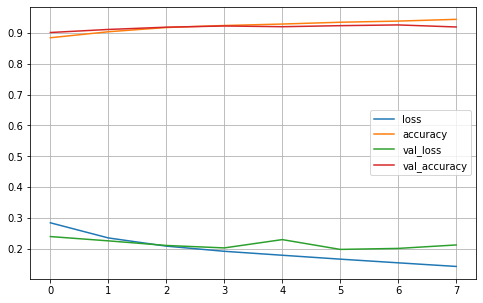

In [104]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [105]:
model3.evaluate(X_val_pad,y_val)

184/184 [==============================] - 13s 68ms/step - loss: 0.2134 - accuracy: 0.9185


[0.21337354183197021, 0.9185412526130676]

In [106]:
pred = model3.predict(X_val_pad)
y_pred_model3 = []
for element in pred:
    if element > 0.5:
        y_pred_model3.append(1)
    else :
        y_pred_model3.append(0)

In [107]:
print(classification_report(y_val, y_pred_model3))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1400
           1       0.94      0.95      0.95      4468

    accuracy                           0.92      5868
   macro avg       0.89      0.88      0.89      5868
weighted avg       0.92      0.92      0.92      5868



# Model Evaluation

In [108]:
print('1 LTSM Layer')
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred_model))
print()
print(classification_report(y_val, y_pred_model))
print('-'*35)

print('2 LTSM Layers (5 epochs)')
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred_model2))
print()
print(classification_report(y_val, y_pred_model2))
print('-'*35)

print('2 LTSM Layers (8 epochs)')
print('Confusion Matrix:')
print(confusion_matrix(y_val, y_pred_model3))
print()
print(classification_report(y_val, y_pred_model3))

1 LTSM Layer
Confusion Matrix:
[[1132  268]
 [ 195 4273]]

              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1400
           1       0.94      0.96      0.95      4468

    accuracy                           0.92      5868
   macro avg       0.90      0.88      0.89      5868
weighted avg       0.92      0.92      0.92      5868

-----------------------------------
2 LTSM Layers (5 epochs)
Confusion Matrix:
[[1114  286]
 [ 179 4289]]

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1400
           1       0.94      0.96      0.95      4468

    accuracy                           0.92      5868
   macro avg       0.90      0.88      0.89      5868
weighted avg       0.92      0.92      0.92      5868

-----------------------------------
2 LTSM Layers (8 epochs)
Confusion Matrix:
[[1138  262]
 [ 216 4252]]

              precision    recall  f1-score   support

           0      

All three models performed similarly. Because in this classification both targets are equally important, meaning we want to accurately classify books into either Fiction and Nonfiction, we will choose the model that has the least amount of misclassification. In this case, **the first model is the best choice**. That model will be saved and used in the Model Inference

# Model Saving

Saving best model

In [109]:
model.save('book_genre.h5')

# Model Inference

As mentioned before, we will be using the data of books that have not been classified into Fiction or Nonfiction for the Model Inference

In [110]:
# Loading the final model
model_final = tf.keras.models.load_model('book_genre.h5')

In [111]:
data_inf = data[data['label'] == 'Not Determined']
data_inf.head()

,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label
24,Cassandra Clare|Franca Fritz|Heinrich Koop|Fra...,City of Bones,When fifteen-year-old Clary Fray heads out to ...,Fantasy|Young Adult|Fantasy|Paranormal|Romance,en,English,5,"[Fantasy, Young Adult, Fantasy, Paranormal, Ro...",Not Determined
79,Richelle Mead,Vampire Academy,Only a true best friend can protect you from y...,Young Adult|Paranormal|Vampires|Fantasy|Fantas...,en,English,7,"[Young Adult, Paranormal, Vampires, Fantasy, F...",Not Determined
99,Cassandra Clare,Clockwork Angel,In a time when Shadowhunters are barely winnin...,Fantasy|Young Adult|Fantasy|Paranormal|Science...,en,English,7,"[Fantasy, Young Adult, Fantasy, Paranormal, Sc...",Not Determined
111,Eric Carle,The Very Hungry Caterpillar,"THE all-time classic picture book, from genera...",Childrens|Picture Books|Childrens,en,English,3,"[Childrens, Picture Books, Childrens]",Not Determined
123,Becca Fitzpatrick,"Hush, Hush",A SACRED OATHA FALLEN ANGELA FORBIDDEN LOVERom...,Young Adult|Fantasy|Fantasy|Paranormal|Paranor...,en,English,7,"[Young Adult, Fantasy, Fantasy, Paranormal, Pa...",Not Determined


First, we will clean and preprocess the data, the same way as training and validation data

In [112]:
data_inf_trf = cleaner(data_inf)
data_inf_trf.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,book_authors,book_title,book_desc,genres,language,language_name,num_of_genres,list_of_genres,label,clean_desc
24,Cassandra Clare|Franca Fritz|Heinrich Koop|Fra...,City of Bones,When fifteen-year-old Clary Fray heads out to ...,Fantasy|Young Adult|Fantasy|Paranormal|Romance,en,English,5,"[Fantasy, Young Adult, Fantasy, Paranormal, Ro...",Not Determined,when fifteen year old clary fray heads out to ...
79,Richelle Mead,Vampire Academy,Only a true best friend can protect you from y...,Young Adult|Paranormal|Vampires|Fantasy|Fantas...,en,English,7,"[Young Adult, Paranormal, Vampires, Fantasy, F...",Not Determined,only a true best friend can protect you from y...
99,Cassandra Clare,Clockwork Angel,In a time when Shadowhunters are barely winnin...,Fantasy|Young Adult|Fantasy|Paranormal|Science...,en,English,7,"[Fantasy, Young Adult, Fantasy, Paranormal, Sc...",Not Determined,in a time when shadowhunters are barely winnin...
111,Eric Carle,The Very Hungry Caterpillar,"THE all-time classic picture book, from genera...",Childrens|Picture Books|Childrens,en,English,3,"[Childrens, Picture Books, Childrens]",Not Determined,the all time classic picture book from generat...
123,Becca Fitzpatrick,"Hush, Hush",A SACRED OATHA FALLEN ANGELA FORBIDDEN LOVERom...,Young Adult|Fantasy|Fantasy|Paranormal|Paranor...,en,English,7,"[Young Adult, Fantasy, Fantasy, Paranormal, Pa...",Not Determined,a sacred oatha fallen angela forbidden loverom...


In [113]:
X_inf = data_inf['clean_desc']

In [114]:
X_inf_pad = preprocess_data(X_inf)
X_inf_pad[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,  1145,    23,
          16, 18475, 12120,  1822, 26521,  1093,     3,    49,    58,
        3188,  4162,  1389,   156,    80,   591,   156,  1906,    50,
        2838,  2747,   206, 10803,  1183,  2208,   261,  2090,  2647,
         990,   272,   383,   392,  8714,  2592,   213,   509,   162,
          19,   330,   424,   100,   681,   100, 18475,     8,  1417,
       34071,  1679,  2032, 21623,   174,  1123,    30,     8,   945,
       16098, 57162,   764,    84,    24,  1477,  2048,   958,    24,
       17292,   214,   224,   146,   846, 18475,  2906, 16098,     4,
        1851,    44,  2090, 18475,  3102,  1719,    29,  1123,  2158,
         521,    24, 18475,    44, 18475,   348,    83,  1787, 34071,
          29,    24,    82], dtype=int32)

After that, we will classify the books into Fiction or Nonfiction using the final model

In [115]:
pred = model_final.predict(X_inf_pad)
y_pred_inf = []
for element in pred:
    if element > 0.5:
        y_pred_inf.append(1)
    else :
        y_pred_inf.append(0)

Here are the results:

In [116]:
print('Amount of books classified as Fiction   :', y_pred_inf.count(1))
print('Amount of books classified as Nonfiction:', y_pred_inf.count(0))

Amount of books classified as Fiction   : 13434
Amount of books classified as Nonfiction: 1023


Finally, I want to give a demo as if we want to know if a book is Fiction or Nonfiction by manually inputing a description of a book

For this, we will be selecting a random data from the inference data

In [117]:
data_inf.iloc[10]

book_authors                                           Rick Riordan
book_title                              The Battle of the Labyrinth
book_desc         Percy Jackson isn't expecting freshman orienta...
genres                        Fantasy|Young Adult|Fantasy|Mythology
language                                                         en
language_name                                               English
num_of_genres                                                     4
list_of_genres           [Fantasy, Young Adult, Fantasy, Mythology]
label                                                Not Determined
clean_desc        percy jackson is not expecting freshman orient...
Name: 172, dtype: object

The randomly chosen data is a Percy Jackson book, which is a widely known Fantasy and Mythology book. If the model performed well, it should be able to predict that this book is Fiction

In [118]:
data_inf.iloc[10]['book_desc']

"Percy Jackson isn't expecting freshman orientation to be any fun. But when a mysterious mortal acquaintance appears at his potential new school, followed by demon cheerleaders, things quickly move from bad to worse.In this fourth installment of the blockbuster series, time is running out as war between the Olympians and the evil Titan lord Kronos draws near. Even the safe haven of Camp Half-Blood grows more vulnerable by the minute as Kronos's army prepares to invade its once impenetrable borders. To stop the invasion, Percy and his demigod friends must set out on a quest through the Labyrinth - a sprawling underground world with stunning surprises at every turn."

In [119]:
inf = 'Percy Jackson isn\'t expecting freshman orientation to be any fun. But when a mysterious mortal acquaintance appears at his potential new school, followed by demon cheerleaders, things quickly move from bad to worse.In this fourth installment of the blockbuster series, time is running out as war between the Olympians and the evil Titan lord Kronos draws near. Even the safe haven of Camp Half-Blood grows more vulnerable by the minute as Kronos\'s army prepares to invade its once impenetrable borders. To stop the invasion, Percy and his demigod friends must set out on a quest through the Labyrinth - a sprawling underground world with stunning surprises at every turn.'

In [120]:
a = clean_text(inf)
a

'percy jackson is not expecting freshman orientation to be any fun but when a mysterious mortal acquaintance appears at his potential new school followed by demon cheerleaders things quickly move from bad to worse in this fourth installment of the blockbuster series time is running out as war between the olympians and the evil titan lord kronos draws near even the safe haven of camp half blood grows more vulnerable by the minute as kronos is army prepares to invade its once impenetrable borders to stop the invasion percy and his demigod friends must set out on a quest through the labyrinth a sprawling underground world with stunning surprises at every turn'

In [121]:
txt_samp = pd.Series([a])

In [122]:
txt_samp

0    percy jackson is not expecting freshman orient...
dtype: object

In [123]:
def reviewBook(model,text):
    labels = ['Nonfiction', 'Fiction']
    a = preprocess_data(txt_samp)
    output = model.predict(a, batch_size=1)
    score = (output>0.5)*1
    pred = score.item()
    return labels[pred]

In [124]:
reviewBook(model_final,txt_samp)

'Fiction'

# Conclusion

From Data Exploration, we found that:
1. Most of the book descriptions are in English
2. Most books are classified into 5-6 different genres
3. The top genre for Fictional books is Fantasy
4. The top genre for Non-Fictional books is Biography
***
In Data Preprocessing, we first cleaned the book description by:
- Removing non-ascii characters, numbers, and punctuation
- Replacing shortened words with their original form
- Turning all letters into lowercase

After that, we prerpocessed the cleaned data by:
- Removing stopwords
- Splitting the sentences into individual words
- Doing lemmatization
- Encoding the words into numbers
***
We made three different models to see which one has the best performance. All three models performed similarly. But in the end, we chose the model with one embedding layer, one LTSM layer, one dropout layer, and one sigmoid layer as our final model because that's the model that gives the least amount of misclassification
***
The final model is saved and used in Model Inference. In Model Inference, we classified the books in this dataset that hasn't been classified into Fiction or Nonfiction. The results are:
- 13434 books are classified as Fiction
- 1023 are classified as Nonfiction

We also tried classifying a book by manually inputing the description. The model successfully predicted a Percy Jackson book as Fiction
